# Time-series Prediction using XGBoost Regressor

----

## Introduction
XGBoost is a powerful and versatile tool, which has enabled many Kaggle competition participants to achieve winning scores. How well does XGBoost perform when used to predict future values of a time-series? This was put to the test by aggregating datasets containing time-series from three Kaggle competitions. Random samples were extracted from each time-series, with lags of t-10 and a target value (forecast horizon) of t+5. Up until now, the results have been interesting and warrant further work.

## Imports

In [544]:
# Standard imports
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from math import sqrt

# Modifying and splitting the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# XGboost model
import xgboost as xgb

# Model selection tools
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Saving models
from sklearn.externals import joblib

# Error metrics
from sklearn.metrics import mean_squared_error, r2_score

## Classes

In [535]:
'''Takes specified number of time-series from dataset and then randomly creates specified number of training
examples (each with a target value) from each time-series. For example, if 1000 time-series are specified, 
where 10 examples are taken from each time-series, the X-matrix will have shape: (10000, 10).

sample_num = number of sequences taken from each time-series
lag = number of preceding points to use for the prediction
lead = the forecast horizon (target value)'''

class create_inputs:
    def __init__(self, sample_num, lag, lead):
        self.sample_num = sample_num
        self.lag = lag
        self.lead = lead
    
    def fit(self, X, y=None):
        self.X = X
    
    # X must be an numpy matrix or array
    def transform(self, X, y=None):
        X_matrix = []
        y = []

        for row in range(len(X)):

            ts = self.X[row]

            for i in range(self.sample_num):
                np.random.seed(i)
                start_point = np.random.randint(1, len(ts) - self.lag - self.lead)

                sample = []
                for n in range(self.lag + 1):
                    sample.append(ts[start_point + n])

                X_matrix.append(sample)
                y.append(ts[start_point + self.lag + self.lead])

        self.X = np.array(X_matrix)
        self.y = np.array(y)
        return self.X, self.y

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y=None)


## Stand-alone functions

In [577]:
# creates training examples for supervised learning from a time-series (i.e. X: t-n, t-1, t; y: t+1)
# lag is the number of preceding points used for the prediction (X), and lead is the forecast horizon (y)
def timeseries_to_supervised(data, lag=1, lead=1):
    df = pd.DataFrame(data)
    columns = [df.shift(-i) for i in range(0, lag+1)]
    df_X = pd.concat(columns, axis=1)
    df_all = pd.concat([df_X, df.shift(-(lead + lag))], axis=1)
    df_all = df_all.iloc[:-(lead + lag), :]
    df_all.fillna(0, inplace=True)
    return df_all

# saving a model
def save_model(model, filename):
    return joblib.dump(model, filename)

# loading a model
def load_model(filename):
    return joblib.load(filename)

def calculate_SMAPE(y, y_hat):
    print('SMAPE score: ', 100 / len(y) * np.sum(np.abs(y_hat - y) / ((np.abs(y) + np.abs(y_hat))/2)))

## Data loading and preparation

#### Wikipedia views data
Web Traffic Time Series Forecasting
https://www.kaggle.com/c/web-traffic-time-series-forecasting

Time-series data from 1000 pages used.

In [537]:
views_df = pd.read_csv('./datasets/wikipedia-views_train.csv', index_col=0)

In [562]:
views_df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,37.0,9.0,7.0,13.0,11.0,54.0,14.0,14.0,33.0,12.0,...,19.0,27.0,19.0,31.0,13.0,23.0,45.0,28.0,30.0,19.0
1,8.0,2.0,7.0,6.0,48.0,14.0,2.0,6.0,13.0,84.0,...,17.0,18.0,66.0,13.0,17.0,57.0,31.0,25.0,36.0,17.0
2,23.0,11.0,15.0,17.0,12.0,11.0,6.0,15.0,21.0,17.0,...,18.0,14.0,17.0,22.0,11.0,21.0,25.0,21.0,17.0,8.0
3,23.0,9.0,6.0,1.0,1.0,1.0,6.0,2.0,0.0,10.0,...,7.0,8.0,10.0,4.0,4.0,6.0,10.0,4.0,7.0,6.0
4,3.0,3.0,3.0,2.0,3.0,2.0,6.0,2.0,7.0,1.0,...,10.0,14.0,4.0,5.0,11.0,8.0,10.0,6.0,5.0,5.0


#### Supermarkets sales data
Corporación Favorita Grocery Sales Forecasting
https://www.kaggle.com/c/favorita-grocery-sales-forecasting

Time-series data for 1000 items used.

In [415]:
sales_df = pd.read_csv('./datasets/supermarket-sales_train.csv', index_col=0)

In [564]:
sales_df.head()

,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
item_nbr,,,,,,,,,,,,,,,,,,,,,
103520,0.0,37.0,50.0,95.0,168.0,121.0,117.0,64.0,80.0,88.0,...,86.0,78.0,107.0,106.0,97.0,117.0,126.0,87.0,75.0,93.0
103665,7.0,177.0,143.0,190.0,206.0,202.0,135.0,112.0,118.0,130.0,...,136.0,92.0,82.0,81.0,143.0,143.0,103.0,94.0,74.0,80.0
105574,1.0,520.0,341.0,294.0,408.0,490.0,318.0,258.0,275.0,216.0,...,419.0,330.0,261.0,336.0,227.0,277.0,258.0,323.0,233.0,256.0
105575,2.0,734.0,467.0,480.0,718.0,752.0,397.0,351.0,352.0,235.0,...,1078.0,781.0,695.0,685.0,564.0,768.0,729.0,860.0,602.0,549.0
105576,0.0,313.0,213.0,206.0,255.0,289.0,160.0,166.0,121.0,129.0,...,704.0,516.0,503.0,465.0,427.0,483.0,898.0,551.0,424.0,657.0


#### Restaurant vistors data
Recruit Restaurant Visitor Forecasting
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

Time-series data for 100 restaurant outlets used.

In [417]:
visitors_df = pd.read_csv('./datasets/restaurant-visits_train.csv', index_col=0)

In [566]:
visitors_df.head()

,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_04341b588bde96cd,10.0,0.0,0.0,23.0,35.0,33.0,52.0,47.0,71.0,32.0,...,33.0,35.0,47.0,30.0,31.0,34.0,35.0,8.0,47.0,45.0
air_05c325d315cc17f5,29.0,21.0,24.0,18.0,15.0,19.0,17.0,16.0,32.0,6.0,...,11.0,24.0,39.0,32.0,20.0,39.0,18.0,28.0,24.0,47.0
air_0728814bd98f7367,0.0,0.0,0.0,0.0,0.0,7.0,12.0,5.0,20.0,20.0,...,5.0,4.0,16.0,2.0,4.0,4.0,11.0,4.0,6.0,27.0
air_08ba8cd01b3ba010,11.0,23.0,19.0,1.0,0.0,3.0,6.0,13.0,13.0,19.0,...,14.0,10.0,13.0,14.0,5.0,0.0,5.0,5.0,14.0,14.0
air_1c95a84924d72500,0.0,0.0,0.0,0.0,16.0,23.0,15.0,18.0,31.0,23.0,...,11.0,12.0,9.0,3.0,13.0,17.0,4.0,10.0,11.0,7.0


### Concatenating all datasets into one dataset
Time-series from each dataset have varying periods, so the input creation class is called separately for each dataset in order to create training sets for supervised learning. Once training sets have been created, they are concatenated into one X-matrix and with a corresponding y-vector containing the target variables.

In [612]:
# create a list of datasets to iterate through
datasets = [views_df, sales_df, visitors_df]

Xs = pd.DataFrame()
ys = pd.DataFrame()

# set input creation parameters
sample_num, lag, lead = 10, 10, 5

# iterate through datasets, create random supervised learning examples and combine into one training set
for dataset in datasets:
    input_setup = create_inputs(sample_num, lag, lead)
    data = dataset.as_matrix()
    X, y = input_setup.fit_transform(data)
    Xs  = Xs.append(pd.DataFrame(X))
    ys = ys.append(pd.DataFrame(y))

X_train = Xs.as_matrix()
y_train = ys.as_matrix()

## Configuring optimal XGBoost model

In [614]:
# setup regressor
xgb_model = xgb.XGBRegressor()

# perform a grid search
tweaked_model = GridSearchCV(
    xgb_model,
    {
        'max_depth': [1, 2, 5, 10, 20],
        'n_estimators': [20, 30, 50, 70, 100],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    cv=10,
    verbose=1,
    n_jobs=-1,
    scoring='neg_median_absolute_error'
)

tweaked_model.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


Best: -32.059161 using {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 20}


In [615]:
save_model(tweaked_model, './models/XGB-model_lag=10_lead=5.pkl')

['./models/XGB-model_lag=10_lead=5.pkl']

## Making predictions using random time-series
Six time-series are used from each dataset, which were put aside in the beginning for the purpose of testing.

### Loading of time-series examples

#### Views for various Wikipedia pages

In [493]:
# used to convert time-series index values to datetime format
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

# wikipedia examples saved in separate files
wikipedia_examples = {
    'DE':'de-wikipedia_series(Rubinrot).csv',
    'EN':'en-wikipedia_series(Ellen_DeGeneres).csv',
    'FR':'fr-wikipedia_series(Crue_de_la_Seine).csv',
    'JP':'jp-wikipedia_series(メジャー_(アニメ)).csv',
    'RU':'ru-wikipedia_series(Ломоносов).csv',
    'CN':'zh-wikipedia_series(蕭正楠).csv'
}

path = './datasets/test_examples/wikipedia-pages/'

# append each time-series to list
views_test_samples = []
for key in wikipedia_examples:
    series = pd.read_csv(path + wikipedia_examples[key], index_col=0, header=None, parse_dates=[0], squeeze=True, date_parser=parser)
    views_test_samples.append(series)

#### Sales for various supermarket items

In [500]:
path = './datasets/test_examples/supermarket-items/'
sales_test_df = pd.read_csv(path + 'supermarket-sales_test.csv', index_col=0)

# create random indices for collecting time-series at random
np.random.seed(42)
rand_idx = np.random.randint(len(sales_test_df), size=6)

# append each time-series to list
sales_test_samples = []
for idx in rand_idx:
    series = pd.Series(sales_test_df.iloc[idx], index = pd.to_datetime(sales_test_df.iloc[idx].index))
    sales_test_samples.append(series)

#### Visits for various restaurant outlets

In [495]:
path = './datasets/test_examples/restaurant-stores/'
visitors_test_df = pd.read_csv(path + 'restaurant-visits-test.csv', index_col=0)

# append each time-series to list
visitors_test_samples = []
for idx in range(len(visitors_test_df)):
    series = pd.Series(visitors_test_df.iloc[idx], index = pd.to_datetime(visitors_test_df.iloc[idx].index))
    visitors_test_samples.append(series)

#### All sample sets combined into one collection

In [509]:
test_collection = {
    'Wikipedia views': views_test_samples,
    'Supermarket sales': sales_test_samples,
    'Restaurant visitors': visitors_test_samples
}

### Predicting
For prediction, samples are extracted using the 'walk-through' technique; that is, points are selected sequentially from the beginning of the time-series to the end, and each point's corresponding lag (a lag of t-5 in this case) is used to predict the target (a forecast horizon of t+5 in this case).

Subplots are plotted comparing the actual time-series with the predicted time-series for each of the six examples across the three cases that are being explored - Wikipedia views, supermarket sales and restaurant visiters.

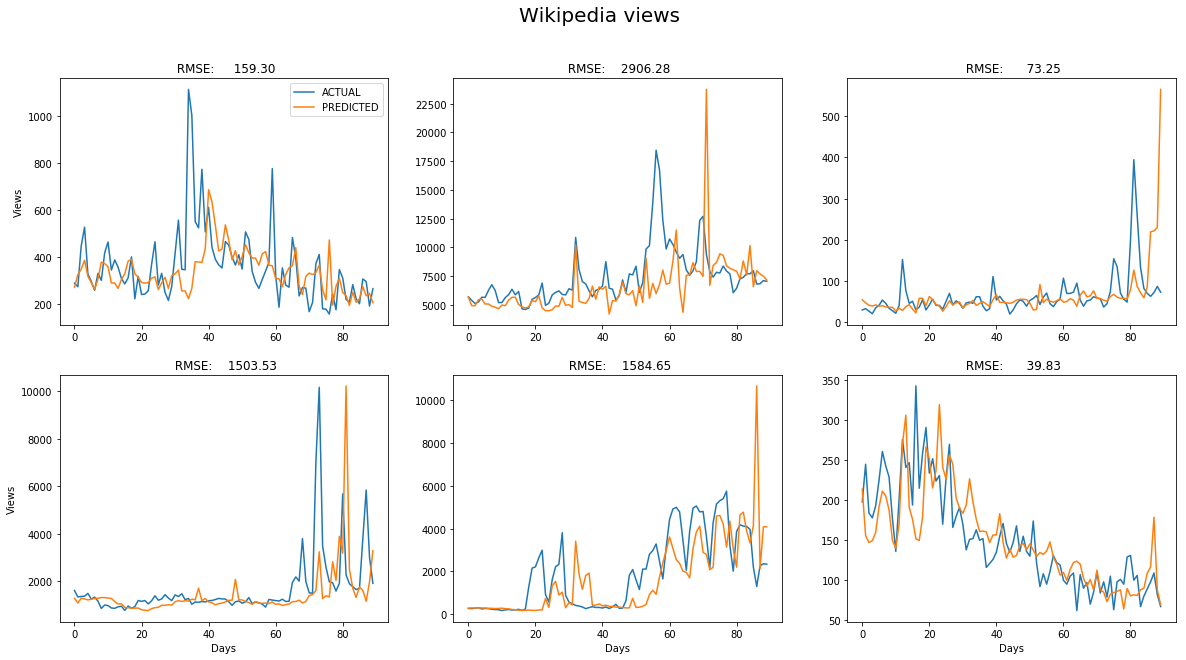

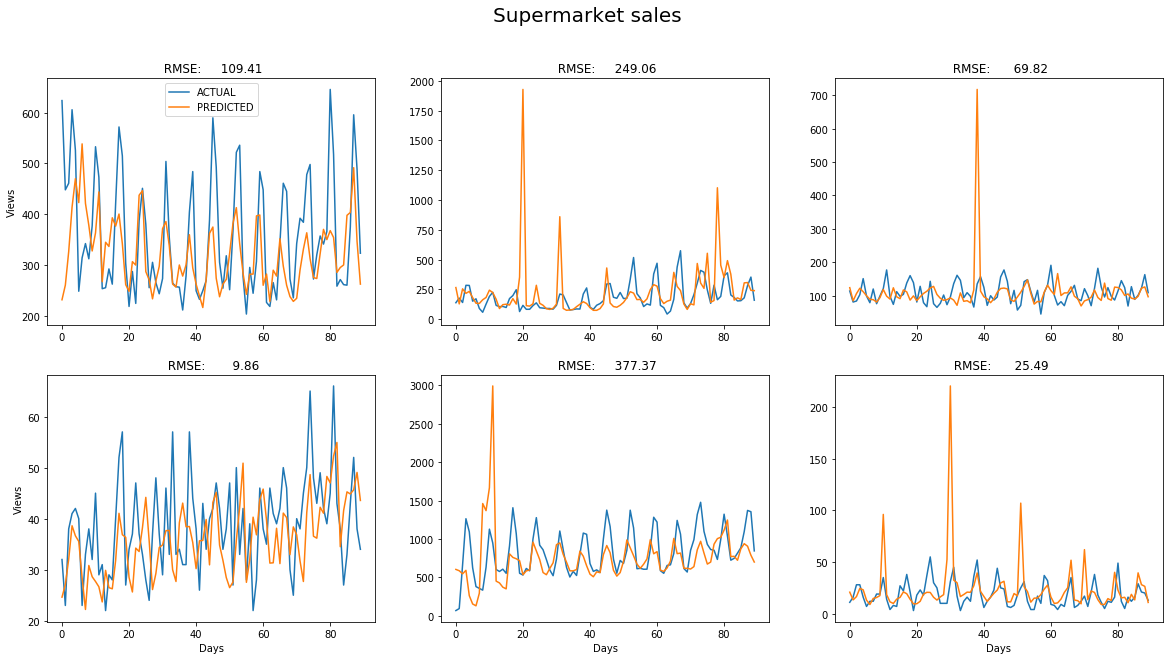

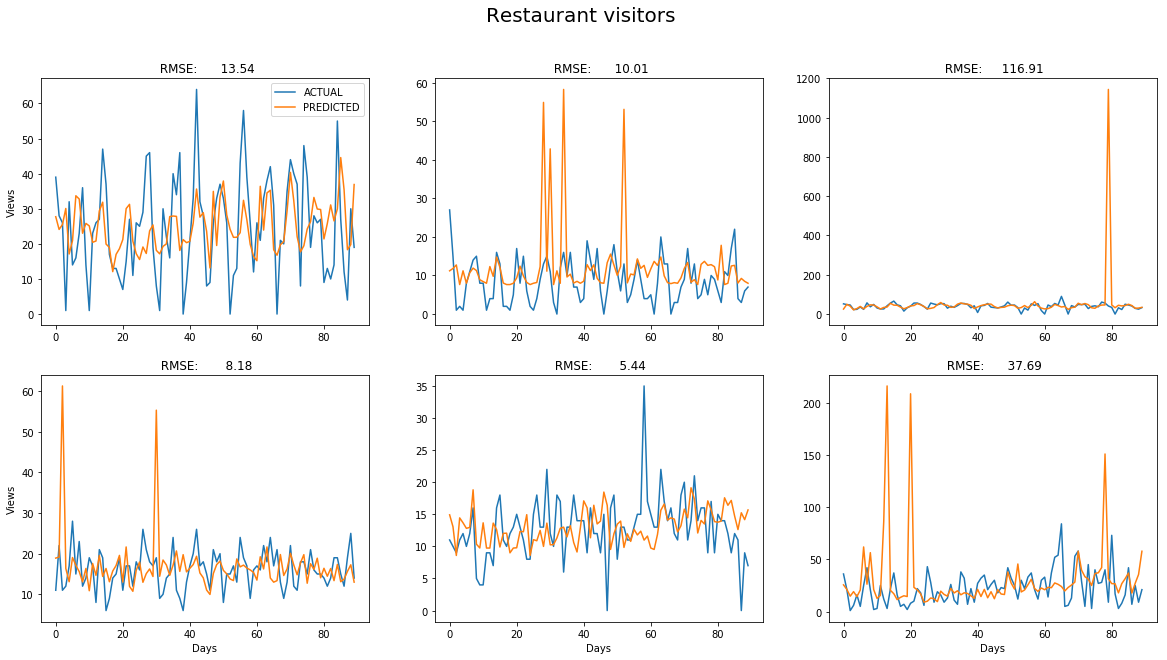

In [617]:
model = load_model('./models/XGB-model_lag=10_lead=5.pkl')

# set prediction parameters
lag, lead = 10, 5  # lead = number of previous points to use, and lead is the forecast horizon

for case in test_collection:
    test_samples = test_collection[case]
    all_targets, all_predictions = [], []
    for series in test_samples:
        series = series[:105] # roughly first 90 days

        # transform data to be supervised learning
        supervised = timeseries_to_supervised(series.values, lag, lead).as_matrix()
        predictors, targets = supervised[:, :-1], supervised[:, -1]
        predictions = model.predict(predictors)
        all_targets.append(targets)
        all_predictions.append(predictions)
        
    # setup plot
    f, ax = plt.subplots(2, 3, figsize=(20,10))
    f.suptitle(case, fontsize=20)

    # create an array of plots for case (3 by 2)
    count = 0
    for i in range(2):
        for j in range(3):
            ax[i, j].plot(all_targets[count], label='ACTUAL')
            ax[i, j].plot(all_predictions[count], label='PREDICTED')
            ax[i, j].set_title(' RMSE: {:10.2f}'.format(np.sqrt(mean_squared_error(all_targets[count], all_predictions[count]))))
            
            count += 1

    # add labels to plots    
    ax[0, 0].legend()
    ax[0, 0].set_ylabel('Views')
    ax[1, 0].set_ylabel('Views')
    ax[1, 0].set_xlabel('Days')
    ax[1, 1].set_xlabel('Days')
    ax[1, 2].set_xlabel('Days')


As you can see, the results are especially good when the model is used to predict supermarket sales, whose time-series have stable trends and seasonality, and appear to have less noise. About half of the graphs show that the model spikes significantly in places. This might be rectified by increasing the number of examples used to train the model.